### MNIST data set

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

KeyboardInterrupt: 

In [ ]:
#define X and y
X,y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


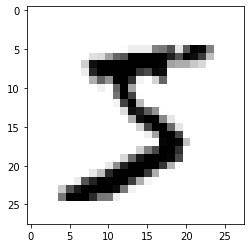

In [ ]:
#show an image
import matplotlib.pyplot as plt
digit = X.loc[0].values
digit_image = digit.reshape(28,28) #each image is formed by 784 pixels (28x28 array)
plt.imshow(digit_image,cmap='binary')

In [ ]:
y[0] == '5'

True

In [ ]:
#cast the label to integer
y = y.astype('int64')

In [ ]:
#train test split
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a binary classifier
- 5-detector

In [ ]:
y_train_5 = (y_train==5) #if 5, then True, else False
y_test_5 = (y_test==5)

In [ ]:
#define a classifier - Stochastic Gradient Descent (SGD)
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=42)
sgd.fit(x_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
#predict the label for a given instance
sgd.predict([digit])

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([ True])

### Performance measures

In [ ]:
#define a cross-validation 
from sklearn.model_selection import cross_val_score
scores = cross_val_score(sgd, x_train, y_train_5, cv=3, scoring='accuracy')
print(scores)

[0.95035 0.96035 0.9604 ]


In [ ]:
#check class ratio - more than 90% of the instances are False
y_train_5.value_counts(normalize=True)

False    0.90965
True     0.09035
Name: class, dtype: float64

In [ ]:
#train a Dumb Classifier
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')
cross_val_score(dummy_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

### Confusion matrix

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd,x_train,y_train_5,cv=3)

In [ ]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### Precision vs Recall

Precision = TP/(TP+FP): based on the positive predictions, how much did the classifier right?

Recall = TP/(TP+FN): based on the positive instances, how much did the classifier detect?

In [ ]:
from sklearn.metrics import precision_score, recall_score
print('Precision:', precision_score(y_train_5, y_train_pred))
print('Recall:', recall_score(y_train_5, y_train_pred))


Precision: 0.8370879772350012
Recall: 0.6511713705958311


### F-score
- Harmonic mean of precision and recall
- The generalization is the fbeta_score. When beta < 1, it favors precision, when beta > 1 , it favors recall

In [ ]:
from sklearn.metrics import f1_score, fbeta_score
print('F1-Score:',f1_score(y_train_5, y_train_pred))
print('F2-score:', fbeta_score(y_train_5, y_train_pred, beta=2))
print('F0.5-score:', fbeta_score(y_train_5, y_train_pred, beta=0.5))

F1-Score: 0.7325171197343846
F2-score: 0.6814408710088414
F0.5-score: 0.7918704293597739


### Precision/Recall trade-off
- To assign True or False, the classifer computes a decision function and based on a certain threshold, if the decision score for a given is greater than the threshold, the prediction will be True, otherwise False. 

In [ ]:
#computes the decision score for each instance
y_scores = cross_val_predict(sgd, x_train, y_train_5, cv=3, method='decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, th = precision_recall_curve(y_train_5, y_scores)

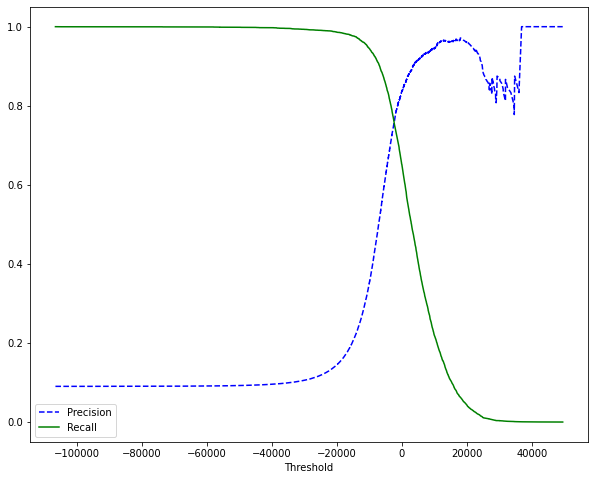

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(th, precisions[:-1], 'b--',label='Precision')
plt.plot(th, recalls[:-1], 'g-',label='Recall')
plt.xlabel('Threshold')
plt.legend()

Text(0, 0.5, 'Precision')

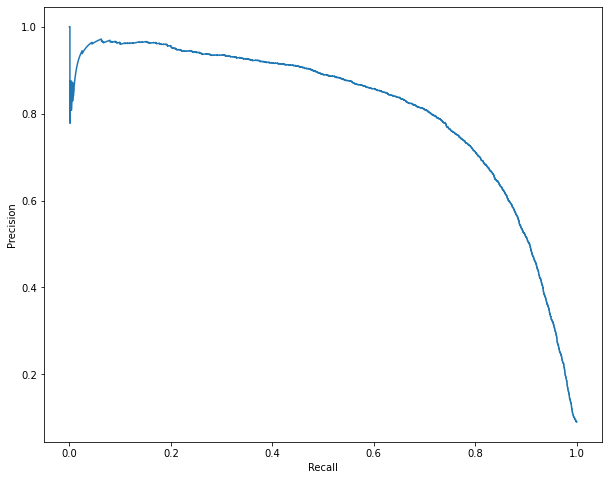

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(recalls,precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')

In [ ]:
#goal: obtain a 90% precision classifier
import numpy as np
threshold_90_pr = th[np.argmax(precisions >= .9)]
threshold_90_pr

3370.019499143958

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_pr)

In [ ]:
print('Precision: ', precision_score(y_train_5, y_train_pred_90))
print('Recall: ',recall_score(y_train_5, y_train_pred_90))

Precision:  0.9000345901072293
Recall:  0.4799852425751706


### ROC Curve
- plots the True Positive rate versus the False Positive rate

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, th = roc_curve(y_train_5, y_scores)

Text(0, 0.5, 'True Positive Rate')

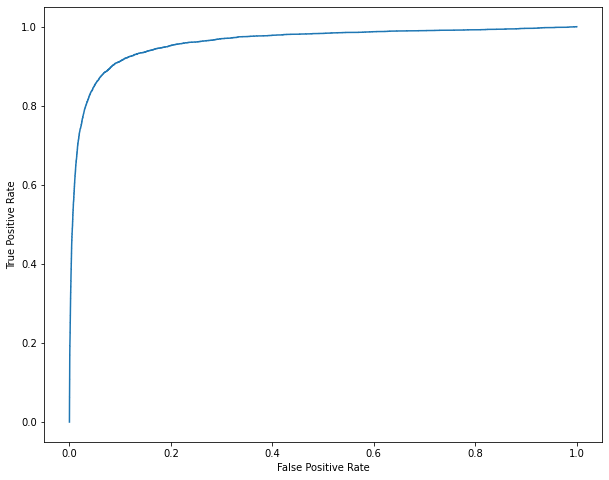

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
from sklearn.metrics import roc_auc_score
print('AUC:', roc_auc_score(y_train_5, y_scores))

AUC: 0.9604938554008616


If we care more about the False positive rate or the positive class is rare, prefer using the Precision-Recall curve. Otherwise , use ROC curve.

### Training a Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(rf,x_train, y_train_5, method='predict_proba', cv=3)
y_scores_forest = y_probas_forest[:,1] #proba of positive class
fpr_rf, tpr_rf, th = roc_curve(y_train_5, y_scores_forest)

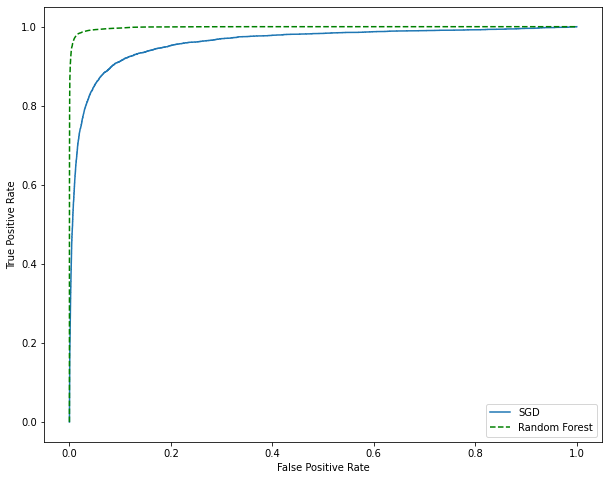

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr,label='SGD')
plt.plot(fpr_rf, tpr_rf,'g--',label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [ ]:
print('AUC SGD:',roc_auc_score(y_train_5, y_scores))
print('AUC Random Forest:',roc_auc_score(y_train_5, y_scores_forest))

AUC SGD: 0.9604938554008616
AUC Random Forest: 0.9983436731328145


### Multiclass problems

- instead of having 2 classes, let's consider more classes.
- some algorithms can natively deal with more than 2 classes, however some of them can not (eg. Logistic Regression, Support Vector Machines, etc)
- for these algorithms uncapable of dealing with more than 2 classes, we can use 2 common strategies called OneversusRest and OneversusOne

In [ ]:
from sklearn.svm import SVC
svc = SVC() #default is OvR
svc.fit(x_train, y_train)
svc.predict([digit])

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([5])

In [ ]:
#the score for class = 5 is the highest one
svc.decision_function([digit])

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2b7eb737-18d4-4683-a9e5-3ea902dd423b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>